In [1]:
# sctour-scvelo environment (make sure scikit-misc is also installed)
# from https://github.com/HaghverdiLab/velocity_notebooks/blob/main/figures_notebooks/HSPC_kappa-velo.ipynb
# Trying out scTour on the data though
# 
# ### load libraries

# standard libraries
import numpy as np
import pandas as pd

# single-cell libraries
import scvelo as scv #used for reading loom file
import anndata as ad
import scanpy as sc

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing the parameters of the scVelo figures

# dimension reductions
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
from scipy.spatial import cKDTree
import umap #for creating UMAP

import sctour as sct

In [2]:
### load loom file subset
hspc_path = "/Users/kevinlin/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/git/velocity_notebooks/datasets/HSPC/HSPC.loom"
adata = ad.read_loom(hspc_path)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
adata

AnnData object with n_obs × n_vars = 3190 × 31053
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [4]:
### load cells selected in qc
load_path = "/Users/kevinlin/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/git/velocity_notebooks/datasets/HSPC/cells_after_qc.csv"
cell_after_qc = np.loadtxt(load_path, dtype=str)

In [5]:
### change cellnames in loom file to match the cellnames from the original dataset
cellnames = [cellname.replace('possorted_genome_bam_YBF44:','') for cellname in adata.obs_names]
cellnames = [cellname.replace('x','-1-PBS') for cellname in cellnames]
adata.obs_names = cellnames

In [6]:
### remove cells that are filtered out in original pipeline (doublets, etc.)
adata = adata[cell_after_qc,:]

In [7]:
### make names of genes unique
adata.var_names_make_unique()

In [8]:
### load genes selected in qc
load_path = "/Users/kevinlin/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/git/velocity_notebooks/datasets/HSPC/genes_after_qc.csv"
genes_after_qc = np.loadtxt(load_path, dtype=str)

In [9]:
### remove genes that are filtered out in original pipeline 
shared_genes = np.intersect1d(adata.var_names, genes_after_qc)
adata = adata[:,shared_genes]

In [10]:
### load original clusters 
load_path = "/Users/kevinlin/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/git/velocity_notebooks/datasets/HSPC/original_clusters.csv"
original_clusters = pd.read_csv(load_path, index_col=0)
adata.obs["original_clusters"] = original_clusters

In [11]:
### load original colors
original_colors = ['#98df8a', '#d62728', '#aec7e8', '#17becf', '#8c564b', '#b5bd61',
                   '#e377c2', '#279e68', '#ff7f0e', '#aa40fc', '#1f77b4', '#ffbb78']
adata.uns["original_clusters_colors"] = original_colors

In [21]:
adata

AnnData object with n_obs × n_vars = 2430 × 26599
    obs: 'original_clusters', 'n_genes_by_counts', 'total_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'original_clusters_colors'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [22]:
adata.X.shape

(2430, 26599)

Fit scVelo

In [12]:
### copy raw dataset for using with scvelo
adata_scvelo = adata.copy()

In [13]:
### run scVelo pipeline
scv.pp.filter_and_normalize(adata_scvelo, 
                            min_shared_counts=20, 
                            n_top_genes=2000)
sc.pp.pca(adata_scvelo)
sc.pp.neighbors(adata_scvelo, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata_scvelo, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata_scvelo, max_iter=100, n_jobs=4)
scv.tl.velocity_graph(adata_scvelo)

Filtered out 18125 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/opt/miniconda3/envs/sctour-scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 4/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:02:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/opt/miniconda3/envs/sctour-scvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [14]:
pca_pts = adata_scvelo.obsm["X_pca"]
reducer = umap.UMAP(random_state=2, n_neighbors=300, min_dist=1, n_components=2, metric="euclidean")
UMAP_data = reducer.fit_transform(pca_pts)

In [16]:
adata_scvelo

AnnData object with n_obs × n_vars = 2430 × 2000
    obs: 'original_clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'original_clusters_colors', 'log1p', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'variance_velocity'
    obsp: 'distances',

/opt/miniconda3/envs/sctour-scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/sctour-scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/sctour-scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/sctour-scvelo/lib/python3.9/site-package

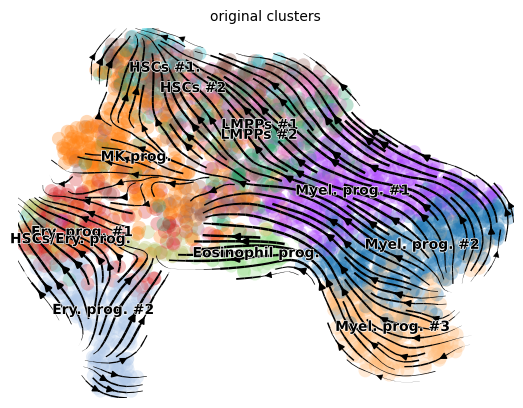

In [17]:
adata_scvelo.obsm["X_umap"] = UMAP_data
scv.pl.velocity_embedding_stream(adata_scvelo, basis='umap', color='original_clusters')

Now try scTour

In [18]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [23]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=1000, subset=True)

In [24]:
tnode = sct.train.Trainer(adata, 
                          loss_mode='nb', 
                          alpha_recon_lec=0.5, 
                          alpha_recon_lode=0.5)
tnode.train()

Running using CPU.
Epoch 400: 100%|██████████| 400/400 [02:15<00:00,  2.95epoch/s, train_loss=538, val_loss=536]


In [25]:
adata.obs['ptime'] = tnode.get_time()

In [26]:
#zs represents the latent z from variational inference, and pred_zs represents the latent z from ODE solver
#mix_zs represents the weighted combination of the two, which is used for downstream analysis
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata.obsm['X_TNODE'] = mix_zs

In [27]:
# adata = adata[np.argsort(adata.obs['ptime'].values), :]
sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

In [29]:
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

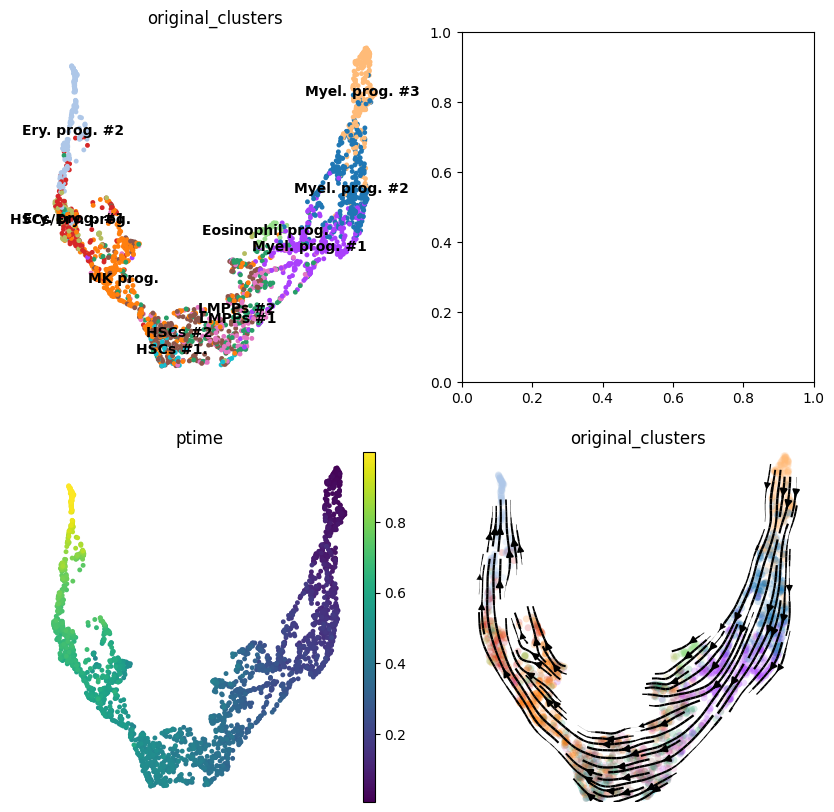

In [31]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.umap(adata, color='original_clusters', ax=axs[0, 0], legend_loc='on data', show=False, frameon=False)
sc.pl.umap(adata, color='ptime', ax=axs[1, 0], show=False, frameon=False)
sct.vf.plot_vector_field(adata, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='original_clusters', show=False, ax=axs[1, 1], legend_loc='none', frameon=False, size=100, alpha=0.2)
plt.show()